In [2]:
import pickle
import json
import os
import numpy as np
from bitsets import bitset
from matplotlib import pyplot as plt
import itertools

In [7]:
def calculate_SV(task, n_clients, experiment_type, round_choice):
    folder = '../fedtask/{}/record/'.format(task)
    if experiment_type == 'ideal':
        prefix = 'fedavg_Mlr_R100_B10.0_E2_LR0.5000_P1.00_S0_LD1.000_WD0.000_AVLIDL_CNIDL_CPIDL_TIDL_'
    elif experiment_type == 'central':
        prefix = 'sv_central_Mlr_R100_B10.0_E2_LR0.5000_P1.00_S0_LD1.000_WD0.000_AVLIDL_CNIDL_CPIDL_TIDL_'
    else:
        raise ValueError('param experiment_type must be in ["ideal", "central"]')
    if round_choice not in ['best', 'last']:
        raise ValueError('param experiment_type must be in ["best", "last"]')
    DICT = dict()
    files = os.listdir(folder)
    files.sort(reverse=True)
    for file in files:
        if file.startswith(prefix):
            with open(os.path.join(folder, file), 'r') as f:
                DICT[file.replace(prefix, '').replace('.json', '')] = np.array(json.load(f)['test_accuracy'])
    DICT['0' * n_clients] = np.zeros(101)
    CLIENTS_BITSET = bitset('clients_bitset', tuple(range(n_clients)))
    SV = list()
    for client in range(n_clients):
        result = 0.0
        rest_clients = [client_ for client_ in range(n_clients) if client_ != client]
        for i in range(0, len(rest_clients) + 1):
            a_i = 0.0
            count_i = 0
            for subset in itertools.combinations(rest_clients, i):
                if round_choice == 'last':
                    a_i += \
                        (
                            DICT[CLIENTS_BITSET(set(subset).union({client})).bits()][-1] - \
                            DICT[CLIENTS_BITSET(subset).bits()][-1]
                        )
                elif round_choice == 'best':
                    a_i += \
                        (
                            DICT[CLIENTS_BITSET(set(subset).union({client})).bits()].max() - \
                            DICT[CLIENTS_BITSET(subset).bits()].max()
                        )
                count_i += 1
            a_i = a_i / count_i
            result += a_i
        result = result / len(range(n_clients))
        SV.append(result)
    SV = np.array(SV)
    # filename = '{}_{}.npy'.format(experiment_type, round_choice)
    # with open(os.path.join('../SV_result/', task, filename), 'wb') as f:
    #     pickle.dump(SV, f)
    print(task, experiment_type, round_choice)
    print(SV)
    return SV

In [8]:
n_clients = 5
for task in [
    'synthetic_classification_cnum5_dist11_skew1.0_seed0'
]:
    for experiment_type in ['ideal', 'central']:
        for round_choice in ['last', 'best']:
            calculate_SV(task, n_clients, experiment_type, round_choice)

synthetic_classification_cnum5_dist11_skew1.0_seed0 ideal last
[0.20628583 0.19963116 0.19720371 0.19353753 0.19147669]
synthetic_classification_cnum5_dist11_skew1.0_seed0 ideal best
[0.20642137 0.20013887 0.1971115  0.19380638 0.1919233 ]
synthetic_classification_cnum5_dist11_skew1.0_seed0 central last
[0.20267076 0.19867684 0.19743812 0.19534951 0.19359974]
synthetic_classification_cnum5_dist11_skew1.0_seed0 central best
[0.20287517 0.19945341 0.19764254 0.19536506 0.19399858]


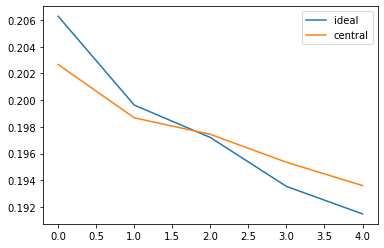

In [11]:
x = np.arange(5)
ideal = [0.20628583, 0.19963116, 0.19720371, 0.19353753, 0.19147669]
central = [0.20267076, 0.19867684, 0.19743812, 0.19534951, 0.19359974]
plt.plot(x,ideal, label='ideal')
plt.plot(x, central, label='central')
plt.legend()
plt.show()